# Анализ рейтинга фильмов iMDB

# Импорт библиотек и разведочный анализ данных 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from scipy import stats
from scipy.stats import ttest_ind, f_oneway, levene, kruskal

import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Загрузка и первичный просмотр данных

In [2]:
df = pd.read_csv('imdb_movie_dataset.csv')
df.head(3)

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0


In [3]:
df.shape

(1000, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Title               1000 non-null   object 
 2   Genre               1000 non-null   object 
 3   Description         1000 non-null   object 
 4   Director            1000 non-null   object 
 5   Actors              1000 non-null   object 
 6   Year                1000 non-null   int64  
 7   Runtime (Minutes)   1000 non-null   int64  
 8   Rating              1000 non-null   float64
 9   Votes               1000 non-null   int64  
 10  Revenue (Millions)  872 non-null    float64
 11  Metascore           936 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 93.9+ KB


In [5]:
df.describe()

,Rank,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,872.000000,936.000000
mean,500.500000,2012.783000,113.172000,6.723200,1.698083e+05,82.956376,58.985043
std,288.819436,3.205962,18.810908,0.945429,1.887626e+05,103.253540,17.194757
min,1.000000,2006.000000,66.000000,1.900000,6.100000e+01,0.000000,11.000000
25%,250.750000,2010.000000,100.000000,6.200000,3.630900e+04,13.270000,47.000000
50%,500.500000,2014.000000,111.000000,6.800000,1.107990e+05,47.985000,59.500000
75%,750.250000,2016.000000,123.000000,7.400000,2.399098e+05,113.715000,72.000000
max,1000.000000,2016.000000,191.000000,9.000000,1.791916e+06,936.630000,100.000000


In [6]:
df.duplicated().sum()

0

## Анализ пропусков 

In [7]:
df.isna().mean()

Rank                  0.000
Title                 0.000
Genre                 0.000
Description           0.000
Director              0.000
Actors                0.000
Year                  0.000
Runtime (Minutes)     0.000
Rating                0.000
Votes                 0.000
Revenue (Millions)    0.128
Metascore             0.064
dtype: float64

Пропуски присутствуют в двух ключевых числовых признаках:
- Revenue (Millions) - данные по кассовым сборам отсутсвуют для некоторого процента фильмов (примерно 13%)
- Metascore - не все фильмы имеют оценку критиков (примерно 6%)

In [8]:
original_df = df.copy()
cleaned_df = df.dropna()

print("До удаления пропусков:")
display(original_df.select_dtypes("number").describe())

print("\nПосле удаления пропусков:")
display(cleaned_df.select_dtypes("number").describe())

# Удаляем пропуски
df.dropna(inplace=True)
print("После очистки пропусков:\n", df.isnull().sum())

До удаления пропусков:


,Rank,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,872.000000,936.000000
mean,500.500000,2012.783000,113.172000,6.723200,1.698083e+05,82.956376,58.985043
std,288.819436,3.205962,18.810908,0.945429,1.887626e+05,103.253540,17.194757
min,1.000000,2006.000000,66.000000,1.900000,6.100000e+01,0.000000,11.000000
25%,250.750000,2010.000000,100.000000,6.200000,3.630900e+04,13.270000,47.000000
50%,500.500000,2014.000000,111.000000,6.800000,1.107990e+05,47.985000,59.500000
75%,750.250000,2016.000000,123.000000,7.400000,2.399098e+05,113.715000,72.000000
max,1000.000000,2016.000000,191.000000,9.000000,1.791916e+06,936.630000,100.000000



После удаления пропусков:


,Rank,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
count,838.000000,838.00000,838.000000,838.000000,8.380000e+02,838.000000,838.000000
mean,485.247017,2012.50716,114.638425,6.814320,1.932303e+05,84.564558,59.575179
std,286.572065,3.17236,18.470922,0.877754,1.930990e+05,104.520227,16.952416
min,1.000000,2006.00000,66.000000,1.900000,1.780000e+02,0.000000,11.000000
25%,238.250000,2010.00000,101.000000,6.300000,6.127650e+04,13.967500,47.000000
50%,475.500000,2013.00000,112.000000,6.900000,1.368795e+05,48.150000,60.000000
75%,729.750000,2015.00000,124.000000,7.500000,2.710830e+05,116.800000,72.000000
max,1000.000000,2016.00000,187.000000,9.000000,1.791916e+06,936.630000,100.000000


После очистки пропусков:
 Rank                  0
Title                 0
Genre                 0
Description           0
Director              0
Actors                0
Year                  0
Runtime (Minutes)     0
Rating                0
Votes                 0
Revenue (Millions)    0
Metascore             0
dtype: int64


Так как оба признака являются количественными и сильно зависят от внешних факторов (популярность, маркетинг, охват релиза и т. д.), заполнять пропуски средними или соседними значениями было бы некорректно — это исказило бы распределения.

Для проверки возможного влияния на данные были рассчитаны основные статистики **до и после удаления пропусков** (`describe()`):  
- Изменения средних значений и медиан составляют менее 5%;  
- Распределения числовых признаков остались практически неизменными.

Вывод:
Удаление пропусков оправдано и не оказывает существенного влияния на общие тенленции в данных

## Проверка распределения оценок критиков и зрителей

Перед проведением статистических тестов важно проверить, соответствуют ли данные нормальному распределению.  
Для этого используем тест Шапиро–Уилка и сравним результаты с визуализацией гистограмм.

Тест Шапиро-Уилка (Metascore): p-value = 0.0001
Распределение не нормальное


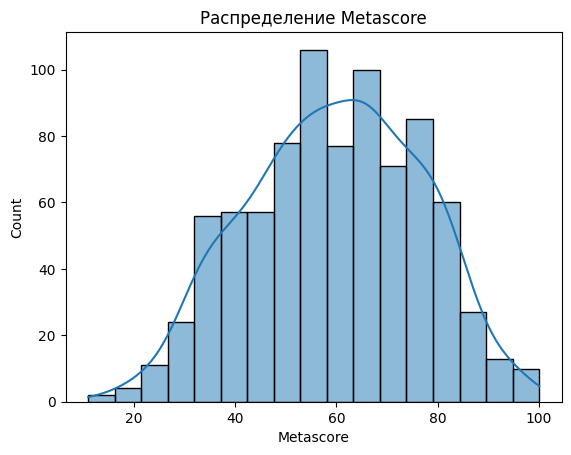

In [9]:
# --- Проверка Metascore ---
stat, p_value = stats.shapiro(df['Metascore'])
print(f"Тест Шапиро-Уилка (Metascore): p-value = {p_value:.4f}")
print("Распределение нормальное" if p_value > 0.05 else "Распределение не нормальное")

sns.histplot(df['Metascore'], kde=True)
plt.title("Распределение Metascore")
plt.show()

Тест Шапиро-Уилка (Rating): p-value = 0.0000
Распределение не нормальное


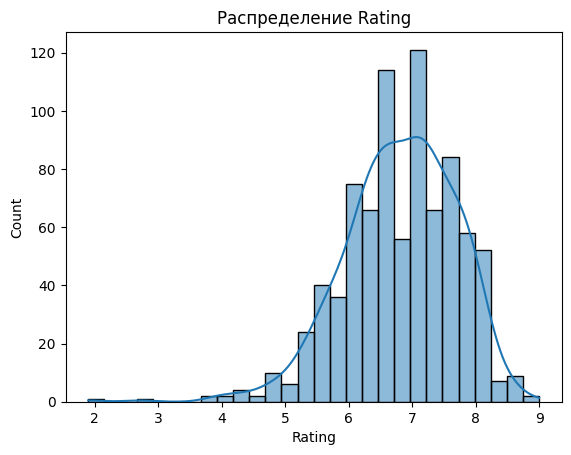

In [10]:
# --- Проверка Rating ---
stat, p_value = stats.shapiro(df['Rating'])
print(f"Тест Шапиро-Уилка (Rating): p-value = {p_value:.4f}")
print("Распределение нормальное" if p_value > 0.05 else "Распределение не нормальное")

sns.histplot(df['Rating'], kde=True)
plt.title("Распределение Rating")
plt.show()

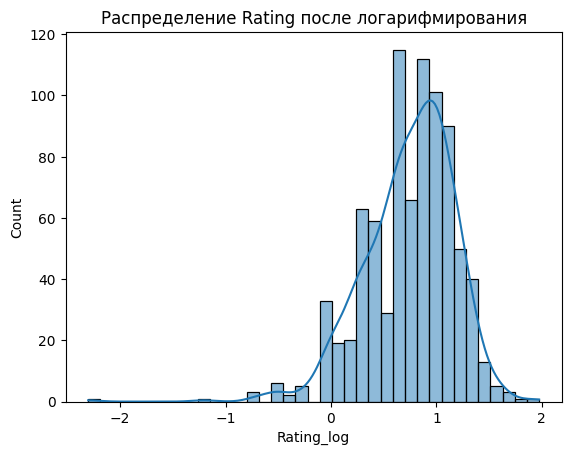

In [11]:
# --- Попытка трансформации Rating ---
df['Rating_log'] = np.log(df['Rating'].max() - df['Rating'] + 1e-1)
sns.histplot(df['Rating_log'], kde=True)
plt.title("Распределение Rating после логарифмирования")
plt.show()

In [12]:
# Логарифмирование не улучшило картину → удаляем вспомогательный столбец
df.drop('Rating_log', axis=1, inplace=True)

### Результаты и интерпретация
- **Metascore**: p-value = 0.0001 → тест Шапиро–Уилка отклоняет гипотезу нормальности.  
  Визуально распределение близко к нормальному, но статистика "видит" отклонения (возможно, из-за размера выборки).  

- **Rating**: p-value = 0.0000 → распределение не нормальное.  
  Гистограмма показывает логнормальное распределение со смещением влево (длинный хвост слева).  

- **Попытка логарифмирования Rating**: даже после трансформации распределение остаётся далеким от нормального.  
  Вероятная причина — наличие нулевых или очень малых значений рейтингов.  

**Вывод**: данные не соответствуют нормальному распределению. Однако, при большом размере выборки (n≈900) ANOVA достаточно устойчива к отклонениям от нормальности, поэтому дальнейший анализ возможен, но результат следует интерпретировать с осторожностью. 


## Анализ категориальных переменных

В исходном датасете столбец `Genre` содержит строку с перечислением жанров через запятую.  
Для статистического анализа и построения моделей удобнее преобразовать его в бинарные признаки (One-Hot-Encoding)


In [13]:
# --- Первичный просмотр категориальных переменных ---
df.describe(include='O')

,Title,Genre,Description,Director,Actors
count,838,838,838,838,838
unique,837,189,838,524,834
top,The Host,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,Ridley Scott,"Jennifer Lawrence, Josh Hutcherson, Liam Hemsw..."
freq,2,50,1,8,2


In [15]:
# --- One-Hot-Encoding для жанров ---
df = df.join(df['Genre'].str.get_dummies(sep=','))

# Удаляем исходный текстовый столбец
df.drop('Genre', axis=1, inplace=True)

In [16]:
# --- Разделяем жанры и не-жанровые признаки ---
non_genre = [
    "Rank", "Title", "Description", "Director", "Actors", "Year", 
    "Runtime (Minutes)", "Rating", "Votes", "Revenue (Millions)", "Metascore"
]
genre = [c for c in df.columns if c not in non_genre]

# Отдельный датафрейм только с жанрами
df_genre = df[genre]
df_genre.head(3)

# Основной датафрейм теперь без жанровых столбцов
df.drop(genre, axis=1, inplace=True)

### Интерпретация
- Столбец `Genre` был преобразован в набор бинарных переменных, где `1` означает принадлежность фильма к жанру, `0` — отсутствие.  
- Такой подход позволяет:
  * легко подсчитать количество фильмов в каждом жанре,
  * проверять различия между жанрами (например, с помощью ANOVA),
  * использовать жанры как отдельные признаки при моделировании.  

Пример: если у фильма стоит `Action=1, Drama=1`, значит, он одновременно относится к боевикам и драме. 

## Кореляционная матрица числовых признаков

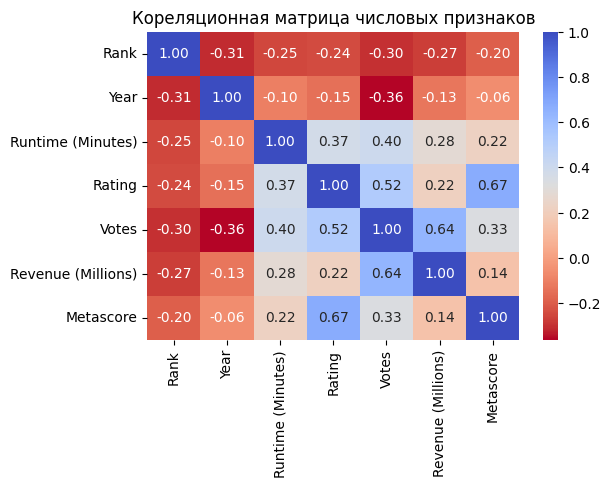

In [17]:
df_num_corr = df[non_genre].corr(numeric_only=True)

plt.figure(figsize=(6,4))
sns.heatmap(
    df_num_corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm_r"
)
plt.title("Кореляционная матрица числовых признаков")
plt.show()

# Вопросы

## В каких жанрах снято наибольшее количество фильмов?

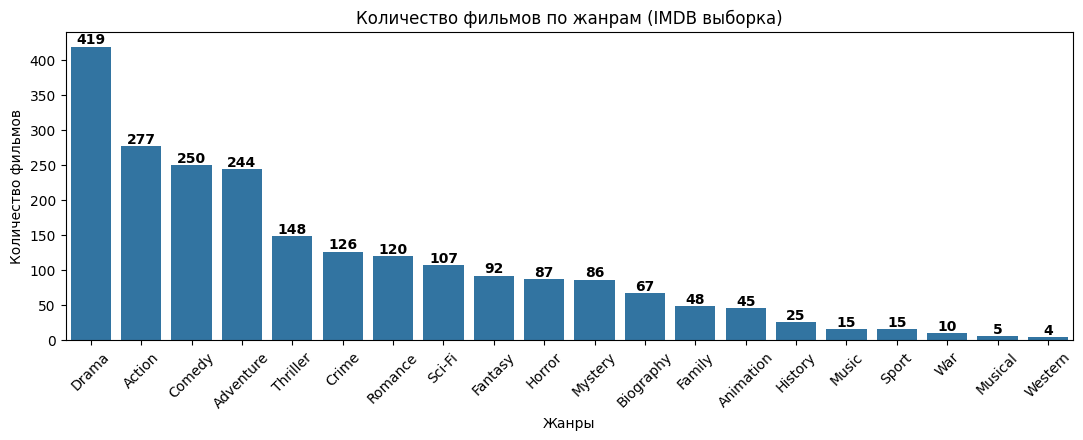

In [18]:
count_sorted_genre = df_genre.sum().sort_values(ascending=False)

plt.figure(figsize=(13, 4))
sns.barplot(x=count_sorted_genre.index, y=count_sorted_genre.values)

# Добавим подписи к столбцам
for i, value in enumerate(count_sorted_genre.values):
    plt.text(i, value, str(value), ha='center', va='bottom', fontweight='bold')

plt.title("Количество фильмов по жанрам (IMDB выборка)")
plt.xlabel("Жанры")
plt.ylabel("Количество фильмов")
plt.xticks(rotation=45)
plt.show()

### Выводы
- Drama в рейтинге сосатвляют 50% за ними идут Action(33%), Comedy(30%) и Adventure(29%).
- Самыми редкими жанрами являются Western (0.5%) и Musical (0.5%)
- Это значит, что при дальнейших статистических тестах редкие жанры могут давать менее надежные результаты из-за малого чилса фильмов

Важно также понимать что несколько жанров могут присутствовать в одном фильме

## Различаются ли средние зрительские рейтинги (Rating) между жанрами?

In [19]:
df = pd.concat([df, df_genre], axis=1)

### 1. Проверка предпосылок ANOVA

In [20]:
# --- Проверка гомогенности дисперсий ---
groups_rating = [df[df[g] == 1]['Rating'].dropna() for g in genre]
stat, p = levene(*groups_rating)
print(f"Levene test (Rating): p={p:.4f}")

Levene test (Rating): p=0.0232


#### Вывод:
- Распределение зрительских рейтингов ранее уже расчитывалось (см. выше p < 0.05).
- Дисперсии между жанрами неоднородные (p < 0.05).
→ Условия для ANOVA нарушены, используем непараметрический тест Крускала–Уоллиса.

### 2.Составление гипотез
- Распределение оценок зрителей на различные жанры не отличаются
- Хотя бы одно распределение оценок зрителей на какой-либо из жанров отличается от других

### 3. Kruskal–Wallis test

Проверяем глобально, есть ли различия между жанрами.  
- H-статистика показывает величину различий.  
- p-value показывает, статистически значимы ли различия (p < 0.05 → есть различия).

In [21]:
stat_r, p_r = kruskal(*groups_rating)
print(f"Kruskal-Wallis (Rating): H={stat_r:.2f}, p={p_r:.4f}")

Kruskal-Wallis (Rating): H=167.54, p=0.0000


### 4. Пост-хок Dunn’s test

In [22]:
df_melted_rating = df.melt(
    id_vars=['Rating'],
    value_vars=df_genre.columns,
    var_name='Genre',
    value_name='Flag'
)

posthoc_r = sp.posthoc_dunn(
    df_melted_rating[df_melted_rating['Flag'] == 1],
    val_col='Rating',
    group_col='Genre',
    p_adjust='bonferroni'
)

signif_count_rating = (posthoc_r < 0.05).sum(axis=1)

median_rating = {}
for g in genre:
    median_rating[g] = df[df[g] == 1]['Rating'].median()

summary = pd.DataFrame({
    'Median': median_rating,
    'Signif_count': signif_count_rating
}).sort_values(by='Median', ascending=False)

print("Итоговая таблица (медиана + количество значимых различий):")
print(summary)

Итоговая таблица (медиана + количество значимых различий):
           Median  Signif_count
War          7.65             1
Animation    7.40             7
Biography    7.40            10
History      7.40             6
Musical      7.40             0
Western      7.25             0
Drama        7.20             6
Sport        7.20             0
Music        7.20             0
Crime        7.00             2
Mystery      7.00             1
Thriller     6.85             2
Adventure    6.80             4
Sci-Fi       6.70             2
Action       6.70             4
Romance      6.70             4
Comedy       6.70             5
Fantasy      6.65             4
Family       6.55             3
Horror       6.30            11


### 5. Визуализация результатов Dunn’s test

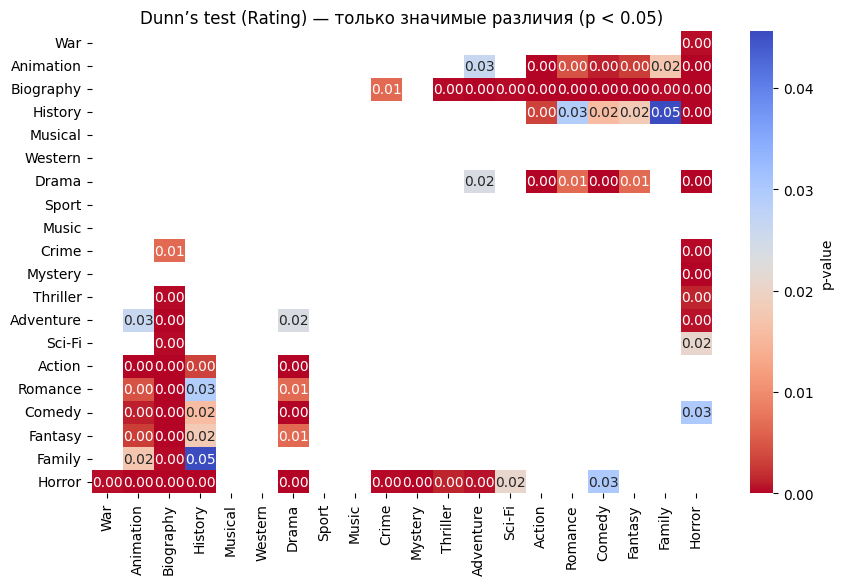

In [23]:
# сортируем heatmap по порядку жанров из summary
ordered_genres = summary.index.tolist()
posthoc_r_sorted = posthoc_r.loc[ordered_genres, ordered_genres]

plt.figure(figsize=(10,6))
sns.heatmap(
    posthoc_r_sorted, 
    annot=True, fmt=".2f", cmap="coolwarm_r",
    cbar_kws={'label': 'p-value'},
    mask=(posthoc_r_sorted >= 0.05)
)
plt.title("Dunn’s test (Rating) — только значимые различия (p < 0.05)")
plt.show()


### 6. Итоги 
| Группа        | Жанры                                 | Медиана | Кол-во значимых различий | Комментарий |
|---------------|---------------------------------------|---------|-------------------------|-------------|
| Топовые       | Biography, Animation, History, War    | 7.40–7.65 | 1–10                    | Высокая оценка и значимые отличия → стабильно любимые зрителями |
| Средние       | Drama, Adventure, Crime, Mystery      | 7.00–7.20 | 1–6                     | Ровные оценки, выделяются умеренно |
| «Прохладные»  | Action, Sci-Fi, Comedy, Romance, Fantasy | 6.65–6.70 | 4–5                     | Популярные, но оценки ниже топовых |
| Низкие / аутсайдер | Family, Horror                     | 6.30–6.55 | 3–11                    | Худшие оценки, Horror особенно выделяется как аутсайдер |


## Различаются ли средние рейтинги критиков (Metascore) между жанрами?

### 1. Проверка предпосылок ANOVA

In [24]:
# --- Проверка гомогенности дисперсий ---
groups_metascore = [df[df[g] == 1]['Metascore'].dropna() for g in genre]
stat, p = levene(*groups_metascore)
print(f"Levene test (Rating): p={p:.4f}")

Levene test (Rating): p=0.0439


#### Вывод:
- Распределение рейтингов критиков ранее уже расчитывалось (см. выше p < 0.05).
- Дисперсии между жанрами неоднородные (p < 0.05).
→ Условия для ANOVA нарушены, используем непараметрический тест Крускала–Уоллиса.

### 2.Составление гипотез
- распределение оценок критиков на различные жанры не отличаются
- хотя бы одно распределение оценок критиков на какой-либо из жанров отличается от других

### 3. Kruskal–Wallis test

Проверяем глобально, есть ли различия между жанрами.  
- H-статистика показывает величину различий.  
- p-value показывает, статистически значимы ли различия (p < 0.05 → есть различия).

In [25]:
stat_r, p_r = kruskal(*groups_metascore)
print(f"Kruskal-Wallis (Rating): H={stat_r:.2f}, p={p_r:.4f}")

Kruskal-Wallis (Rating): H=153.45, p=0.0000


### 4. Пост-хок Dunn’s test

In [26]:
df_melted_metascore = df.melt(
    id_vars=['Metascore'],
    value_vars=df_genre.columns,
    var_name='Genre',
    value_name='Flag'
)

posthoc_m = sp.posthoc_dunn(
    df_melted_metascore[df_melted_metascore['Flag'] == 1],
    val_col='Metascore',
    group_col='Genre',
    p_adjust='bonferroni'
)

signif_count_metascore = (posthoc_m < 0.05).sum(axis=1)

median_metascore = {}
for g in genre:
    median_metascore[g] = df[df[g] == 1]['Metascore'].median()


summary = pd.DataFrame({
    'Median': median_metascore,
    'Signif_count': signif_count_metascore
}).sort_values(by='Median', ascending=False)

print("Итоговая таблица (медиана + количество значимых различий):")
print(summary)

Итоговая таблица (медиана + количество значимых различий):
           Median  Signif_count
Animation    73.0            10
History      73.0             9
Biography    70.0            10
Western      67.0             0
War          66.5             0
Drama        66.0             6
Mystery      62.5             0
Music        62.0             0
Sport        62.0             0
Sci-Fi       61.0             3
Thriller     60.0             2
Comedy       58.5             4
Adventure    58.5             4
Crime        57.5             3
Horror       57.0             4
Musical      56.0             0
Family       56.0             3
Fantasy      55.0             4
Action       54.0             4
Romance      53.5             4


### 5. Визуализация результатов Dunn’s test

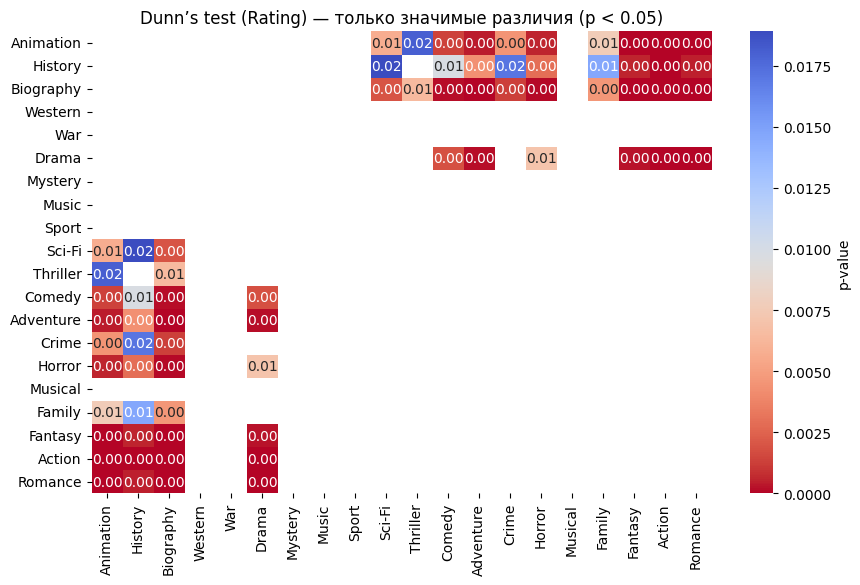

In [27]:
# сортируем heatmap по порядку жанров из summary
ordered_genres = summary.index.tolist()
posthoc_m_sorted = posthoc_m.loc[ordered_genres, ordered_genres]

plt.figure(figsize=(10,6))
sns.heatmap(
    posthoc_m_sorted, 
    annot=True, fmt=".2f", cmap="coolwarm_r",
    cbar_kws={'label': 'p-value'},
    mask=(posthoc_m_sorted >= 0.05)
)
plt.title("Dunn’s test (Rating) — только значимые различия (p < 0.05)")
plt.show()

### 6. Итоги 
| Группа         | Жанры                                   | Медиана | Значимые различия | Комментарий |
|----------------|----------------------------------------|---------|-----------------|-------------|
| Топовые        | Animation, History, Biography          | 70–73   | 9–10            | Высокие медианы и много значимых различий → стабильно любим  критикамими |
| Средние        | Western, War, Drama                     | 66–67   | 0–6             | Средние или высокие медианы; Drama выделяется статистически |
| Средние–слабые | Mystery, Music, Sport, Sci-Fi, Thriller, Comedy, Adventure, Crime, Horror | 57–62   | 0–4             | Медианы ниже топовых; часть жанров выделяется статистически |
| Аутсайдеры     | Musical, Family, Fantasy, Action, Romance | 53.5–56 | 0–4             | Наиболее низкие медикритикиители оценивают хуже осталь |




## Сравнение восприятия зрителей и критиков по жанрам  

| Группа         | Зрители (Rating) – медиана / топ и низ | Критики (Metascore) – медиана / топ и низ | Совпадения и расхождения |
|----------------|-----------------------------------------|--------------------------------------------|--------------------------|
| **Топовые**    | War (7.65), Animation (7.4), Biography (7.4) | Biography (73), History (71), Animation (70) | Совпадение по **Animation** и **Biography**. War ценят зрители, но критики не выделяют. History наоборот — ценят критики. |
| **Средние**    | Drama (7.2), Sport (7.2), Music (7.2)   | Western (67), War (67), Drama (66)         | **Drama** ценится и там, и там, но у критиков чуть ниже. War — высоко у критиков и зрителей, но не топ у критиков. |
| **Середняки–слабые** | Crime (7.0), Mystery (7.0), Thriller (6.85), Comedy (6.7) | Mystery (61), Sci-Fi (60), Comedy (59), Thriller (58) | Заметно совпадение: Comedy, Thriller и Mystery занимают «середину» и у зрителей, и у критиков. |
| **Аутсайдеры** | Horror (6.3), Family (6.55), Fantasy (6.65), Romance (6.7) | Musical (56), Family (55), Fantasy (54), Romance (54), Action (54) | Совпадение по **Family, Fantasy, Romance** → и зрители, и критики считают эти жанры слабыми. У критиков дополнительно слабые Musical и Action. |

---

### Основные выводы
- **Полное совпадение**:  
  - *Animation, Biography* → любимы и зрителями, и критиками.  
  - *Family, Fantasy, Romance* → стабильно в аутсайдерах у обоих.  

- **Разногласия**:  
  - *War* — зрители ставят его на первое место, критики дают средний уровень (такая ситуация может объясняться малым количеством фильмов данного жанра в датасете).  
  - *History* — наоборот: критики ценят, а зрители не выделяют особо.  
  - *Action* — зрители ставят выше (6.7), но критики опускают в аутсайдеры.  

- **Жанры с равнодушием у обоих**: Comedy, Thriller, Mystery → всегда в середине. 

## Сравнение восприятия фильмов зрителями и критиками

Для анализа различий в восприятии фильмов использованы два показателя:

Rating — средняя оценка зрителей (по шкале от 0 до 10);
Metascore — средняя оценка критиков (по шкале от 0 до 100).
Для наглядности построен сравнительный scatter plot, отражающий зависимость между двумя метриками.

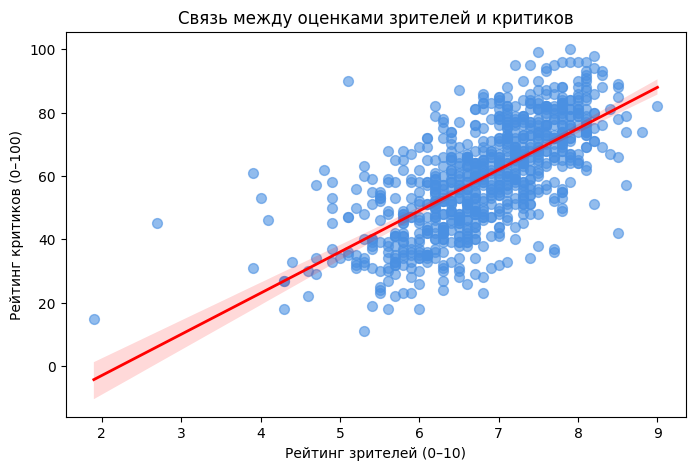

Коэффициент корреляции Пирсона: 0.67


In [28]:
plt.figure(figsize=(8, 5))
sns.regplot(
    x='Rating',
    y='Metascore',
    data=df,
    scatter_kws={'alpha': 0.6, 's': 50, 'color': '#4A90E2'},
    line_kws={'color': 'red', 'lw': 2}
)
plt.title('Связь между оценками зрителей и критиков')
plt.xlabel('Рейтинг зрителей (0–10)')
plt.ylabel('Рейтинг критиков (0–100)')
plt.show()

corr = df[['Rating', 'Metascore']].corr().iloc[0, 1]
print(f'Коэффициент корреляции Пирсона: {corr:.2f}')

Для анализа различий в восприятии фильмов использованы два показателя:
- `Rating` — средняя оценка зрителей (по шкале от 0 до 10);
- `Metascore` — средняя оценка критиков (по шкале от 0 до 100).

Для наглядности построен сравнительный scatter plot, отражающий зависимость между двумя метриками.

**Наблюдения:**
- Большинство зрительских оценок лежит в диапазоне от 5 до 8 баллов, что указывает на умеренно положительное восприятие фильмов.
- Оценки критиков варьируются шире — от 30 до 90, что связано с большей детализацией их шкалы и возможно каким-то другим взгядом на оценку фильмов.
- При этом точки на графике образуют почти линейное облако, что говорит о положительной корреляции между мнениями зрителей и критиков.
- Высокие оценки у зрителей, как правило, сопровождаются высокими оценками у критиков, и наоборот.

**Вывод:**  
Несмотря на различие шкал, общая тенденция показывает, что зрители и критики в целом солидарны в оценке фильмов.  
Иными словами, если фильм нравится зрителям, он с высокой вероятностью получает хорошие отзывы и от профессиональных критиков.

## Самые популярные комбинации жанров

In [29]:
# 1. Берём только фильмы с несколькими жанрами
df_multi = df_genre[df_genre.sum(axis=1) > 1]

# 2. Формируем строку с комбинацией жанров
combo_series = df_multi.apply(
    lambda row: "+".join(row.index[row == 1]),
    axis=1
)

# 3. Считаем частоты комбинаций
combo_counts = combo_series.value_counts()

print("Топ комбинации жанров:")
top_10_combos = combo_counts.head(10)
top_10_df = top_10_combos.to_frame().reset_index()
top_10_df.columns = ['Комбинации', 'Количество']
top_10_df['Процент от всех фильмов'] = round(100 * top_10_df['Количество'] / len(df), 2)

top_10_df

Топ комбинации жанров:


,Комбинации,Количество,Процент от всех фильмов
0,Action+Adventure+Sci-Fi,50,5.97
1,Comedy+Drama+Romance,30,3.58
2,Drama+Romance,27,3.22
3,Adventure+Animation+Comedy,26,3.10
4,Action+Adventure+Fantasy,25,2.98
5,Comedy+Drama,24,2.86
6,Comedy+Romance,22,2.63
7,Crime+Drama+Mystery,18,2.15
8,Crime+Drama+Thriller,18,2.15
9,Action+Adventure+Drama,17,2.03


## Анализ по годам

### 1.Динамика выручки

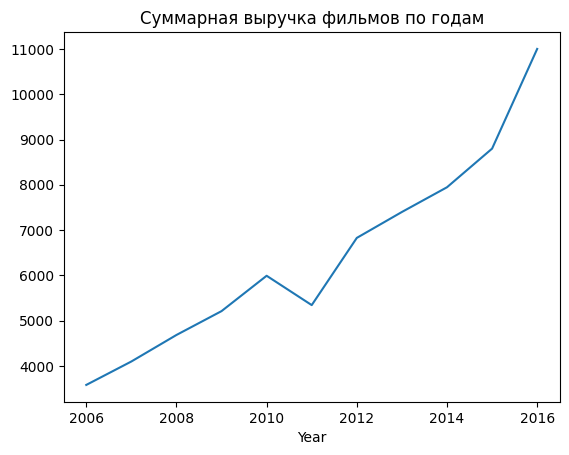

In [30]:
count_year_revenue = df.groupby('Year')['Revenue (Millions)'].sum()
sns.lineplot(x=count_year_revenue.index, y=count_year_revenue.values)
plt.title("Суммарная выручка фильмов по годам")
plt.show()

Вывод: каждый год суммарная выручка фильмов растёт почти линейно.

### 2. Длительность фильмов

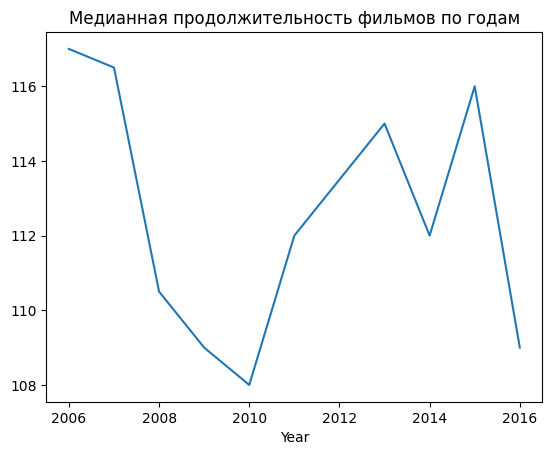

In [31]:
median_runtime = df.groupby('Year')['Runtime (Minutes)'].median()
sns.lineplot(x=median_runtime.index, y=median_runtime.values)
plt.title("Медианная продолжительность фильмов по годам")
plt.show()

Вывод: с 2007 года медианная длительность опустилась ниже 116 минут. В 2010 — минимум 108 минут, в 2016 — новый минимум ~109 минут.

### 3. Количество голосов зрителей

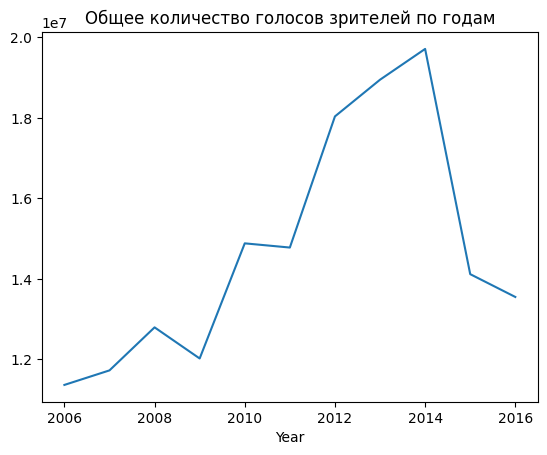

In [32]:
sum_year_votes = df.groupby('Year')['Votes'].sum()
sns.lineplot(x=sum_year_votes.index, y=sum_year_votes.values)
plt.title("Общее количество голосов зрителей по годам")
plt.show()

Вывод: максимум в 2006 (7.15), спад в 2008 (6.7), восстановление до 6.95, затем падение до 6.65 в 2016.

### 4. Средние рейтинги зрителей

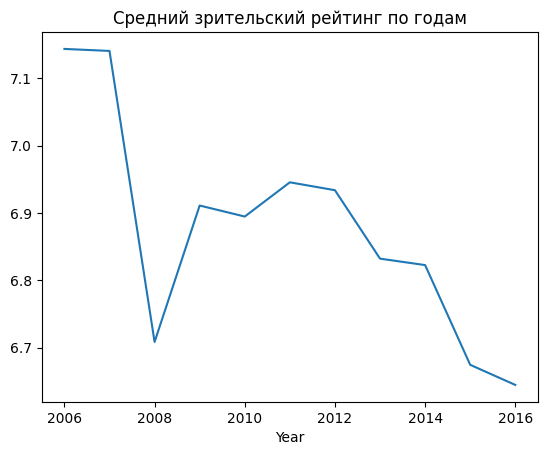

In [33]:
mean_year_rating = df.groupby('Year')['Rating'].mean()
sns.lineplot(x=mean_year_rating.index, y=mean_year_rating.values)
plt.title("Средний зрительский рейтинг по годам")
plt.show()

Вывод: максимум в 2006 (7.15), спад в 2008 (6.7), восстановление до 6.95, затем падение до 6.65 в 2016

### 5. Средние оценки критиков (Metascore)

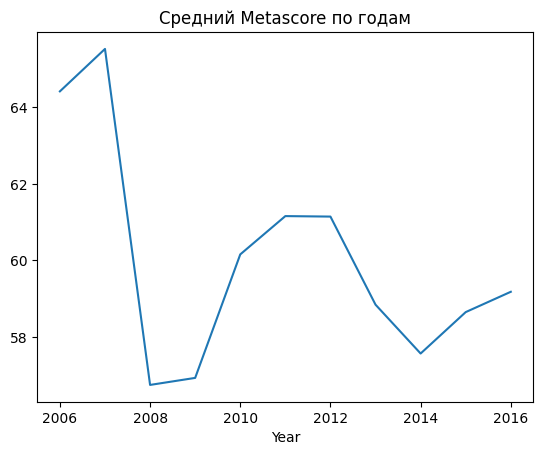

In [34]:
mean_year_metascore = df.groupby('Year')['Metascore'].mean()
sns.lineplot(x=mean_year_metascore.index, y=mean_year_metascore.values)
plt.title("Средний Metascore по годам")
plt.show()

Вывод: максимум в 2007 (65), минимум в 2008 (57), затем рост до 2012 (~61), падение к 2014 (58), новый рост до 61.5 в 2016.

### Итоги анализа по годам
- По выручке видно, что с каждым годом фильмы зарабатывали всё больше. Тренд почти линейный, можно сказать, что рынок стабильно рос.
- Средняя продолжительность фильмов постепенно сокращалась. В середине 2000-х фильмы были дольше двух часов, а к 2016 году опустились ниже 111 минут. Похоже, что студии стали снимать более короткие фильмы.
- По голосам зрителей: до 2014 года их количество росло, а потом резко пошло вниз. Возможно, из-за того, что люди стали активнее пользоваться онлайн-сервисами и реже голосовать на IMDb.
- По зрительскому рейтингу тренд скорее отрицательный. В 2006 году был пик — 7.15, потом оценки постепенно падали и в 2016 были около 6.65.
- Metascore (критики) вёл себя не так ровно: сначала падение, потом рост к 2012, снова падение к 2014 и восстановление к 2016. То есть критики оценивают волнами, но в среднем остаются более стабильными, чем зрители.
- В целом: денег фильмы приносят больше, но зрители становятся строже, а критики держатся более ровно.

## Проверка центральной предельной теоремы

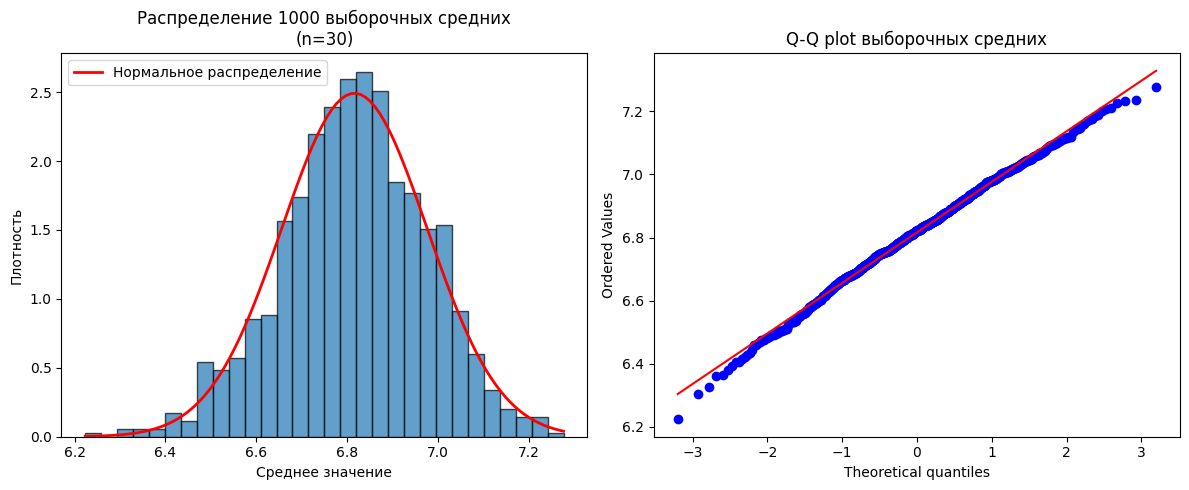

Тест Шапиро-Уилка: p-value = 0.0570
✓ Распределение нормальное

Среднее выборочных средних: 6.816
Среднее исходных данных: 6.814
Стандартная ошибка: 0.160
Объем исходных данных: 838 записей


In [35]:
sample_size = 30    # размер каждой выборки
n_samples = 1000    # количество выборок

# Сбор средних значений
sample_means = []
for i in range(n_samples):
    sample = df['Rating'].dropna().sample(sample_size, random_state=i)  # меняем random_state
    sample_means.append(sample.mean())

# Визуализация
plt.figure(figsize=(12, 5))

# Гистограмма средних
plt.subplot(1, 2, 1)
plt.hist(sample_means, bins=30, alpha=0.7, density=True, edgecolor='black')
plt.title(f'Распределение {n_samples} выборочных средних\n(n={sample_size})')
plt.xlabel('Среднее значение')
plt.ylabel('Плотность')

# Нормальное распределение для сравнения
x = np.linspace(min(sample_means), max(sample_means), 100)
y = stats.norm.pdf(x, np.mean(sample_means), np.std(sample_means))
plt.plot(x, y, 'r-', linewidth=2, label='Нормальное распределение')
plt.legend()

# Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(sample_means, dist="norm", plot=plt)
plt.title('Q-Q plot выборочных средних')

plt.tight_layout()
plt.show()

# Статистические тесты
stat, p_value = stats.shapiro(sample_means)
print(f"Тест Шапиро-Уилка: p-value = {p_value:.4f}")
print("✓ Распределение нормальное" if p_value > 0.05 else "✗ Распределение не нормальное")

# Сравнение с исходными данными
print(f"\nСреднее выборочных средних: {np.mean(sample_means):.3f}")
print(f"Среднее исходных данных: {df['Rating'].mean():.3f}")
print(f"Стандартная ошибка: {np.std(sample_means):.3f}")
print(f"Объем исходных данных: {len(df['Rating'].dropna())} записей")

### Итоги проверки Центральной предельной теоремы

Мы проверили, как работает Центральная предельная теорема (ЦПТ) на данных о зрительских рейтингах фильмов.

- Размер выборки: **n = 30**, количество повторений: **1000**.  
- Распределение выборочных средних визуально близко к нормальному.  
- Тест Шапиро–Уилка показал *p-value = 0.057* (> 0.05), что означает отсутствие статистически значимых отклонений от нормальности.  
- Среднее значение выборочных средних составило **6.816**, что практически совпадает со средним по всей выборке (**6.814**).  
- Стандартная ошибка равна *0.16*, что говорит о небольшом разбросе между средними выборок.

### Вывод
Центральная предельная теорема подтверждается:  
распределение средних значений зрительских рейтингов при большом количестве выборок стремится к нормальному, даже если исходное распределение не идеально нормальное.
о нормальное.
но нормальное.


# Итоговый вывод по анализу фильмов

---

### Корреляционный анализ

Корреляционный анализ показал, что основные количественные показатели фильмов взаимосвязаны.  
**Сильная положительная связь между рейтингами зрителей и оценками критиков (0.67)** подтверждает схожесть их восприятия, а **высокая корреляция между числом голосов и выручкой (0.64)** указывает на то, что популярность напрямую влияет на коммерческий успех.  
При этом **слабая связь между Metascore и Revenue (0.14)** подчёркивает, что критическое признание не всегда гарантирует финансовые результаты.

---

### Жанровой анализ

Наибольшее количество фильмов приходится на жанры **Drama**, **Action** и **Comedy**, при этом наивысшие оценки зрителей и критиков стабильно получают **драмы**, **биографии** и **анимация**.  
Напротив, **хорроры** и **семейные фильмы** чаще получают низкие оценки.  
Популярные комбинации жанров (*Action + Adventure + Sci-Fi*, *Comedy + Drama + Romance*) составляют около **15% всех фильмов**, но не всегда сопровождаются самыми высокими рейтингами.  

Анализ по годам выявил **рост выручки и активности зрителей до 2014 года**, после чего наблюдается **спад вовлечённости** при стабильных средних рейтингах.

---

### Проверка центральной предельной теоремы

Проверка **центральной предельной теоремы (ЦПТ)** показала, что распределение средних выборочных рейтингов приближается к нормальному, что делает использование параметрических статистических методов корректным.

---

### Общие выводы

В целом исследование показало, что успех фильма определяется **сочетанием жанра, восприятия зрителей, популярности и выручки** — ни один показатель не объясняет результат полностью.  
Успех кино остаётся **многокомпонентным явлением**, в котором сочетаются **художественное качество, маркетинг и интерес аудитории**.


